In [161]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import hist
from hist import Hist
import os, sys
import json
import h5py?
import awkward as ak
import uproot
import pickle
import vector
import mplhep as hep
vector.register_awkward()

# parameters for matplotlib styling
plt.style.use(hep.style.CMS)
matplotlib.rcParams.update({'figure.max_open_warning': 0})
matplotlib.rcParams.update({'font.size': 20})

Type:        module
String form: <module 'h5py' from '/home/lavezzo/anaconda3/envs/SUEP/lib/python3.9/site-packages/h5py/__init__.py'>
File:        ~/anaconda3/envs/SUEP/lib/python3.9/site-packages/h5py/__init__.py
Docstring:  
This is the h5py package, a Python interface to the HDF5
scientific data format.


In [162]:
# parameters
tag = '2018_MC'
unblind = False                               # don't show D_exp for SUEP
show = 'all'                                  # set to 'all' or list of plots or plot name
save_to_file = ['A','B']                      # set to 'all' or list of plots or plot name
output_label = 'SUEP'

datasets = [
           "QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8+RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1+MINIAODSIM",
           "QCD_HT100to200_TuneCP5_13TeV-madgraphMLM-pythia8+RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1+MINIAODSIM",
           "QCD_HT1500to2000_TuneCP5_13TeV-madgraphMLM-pythia8+RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1+MINIAODSIM",
           "QCD_HT2000toInf_TuneCP5_13TeV-madgraphMLM-pythia8+RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1+MINIAODSIM",
           "QCD_HT200to300_TuneCP5_13TeV-madgraphMLM-pythia8+RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1+MINIAODSIM",
           "QCD_HT300to500_TuneCP5_13TeV-madgraphMLM-pythia8+RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1+MINIAODSIM",
           "QCD_HT500to700_TuneCP5_13TeV-madgraphMLM-pythia8+RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1+MINIAODSIM",
           "QCD_HT700to1000_TuneCP5_13TeV-madgraphMLM-pythia8+RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1+MINIAODSIM",
           "SUEP-m1000-darkPho+RunIIAutumn18-private+MINIAODSIM",
           "SUEP-m1000-darkPhoHad+RunIIAutumn18-private+MINIAODSIM",
           "SUEP-m1000-generic+RunIIAutumn18-private+MINIAODSIM",
           "SUEP-m125-darkPho+RunIIAutumn18-private+MINIAODSIM",
           "SUEP-m125-darkPhoHad+RunIIAutumn18-private+MINIAODSIM",
           "SUEP-m125-generic+RunIIAutumn18-private+MINIAODSIM",
           "SUEP-m400-darkPho+RunIIAutumn18-private+MINIAODSIM",
           "SUEP-m400-darkPhoHad+RunIIAutumn18-private+MINIAODSIM",
           "SUEP-m400-generic+RunIIAutumn18-private+MINIAODSIM",
           "SUEP-m750-darkPho+RunIIAutumn18-private+MINIAODSIM",
           "SUEP-m750-darkPhoHad+RunIIAutumn18-private+MINIAODSIM",
           "SUEP-m750-generic+RunIIAutumn18-private+MINIAODSIM"
           ]
infile_names = [plotDir+dataset+'_ABCD_plot.pkl' for dataset in datasets]
dataDir = "/work/submit/{0}/SUEP/{1}".format(os.environ['USER'],tag)
plotDir = os.environ['HOME']+"/SUEPCoffea_dask/plotting/"

In [163]:
# load files from pickle
def openpkl(infile_name):
    with (open(infile_name, "rb")) as openfile:
        plots = pickle.load(openfile)
        plots.update(pickle.load(openfile))
    return plots

In [164]:
SUEP_plots, QCD_plots = {}, {}
for dataset, infile_name in zip(datasets, infile_names):
    if not os.path.isfile(infile_name): 
        print("WARNING:",dataset,"doesn't exist")
        continue
    print("Loading",dataset)
    if 'SUEP' in dataset:
        SUEP_plots[dataset] = openpkl(infile_name)
    if 'QCD' in dataset:
        QCD_plots[dataset] = openpkl(infile_name)

Loading QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8+RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1+MINIAODSIM
Loading QCD_HT100to200_TuneCP5_13TeV-madgraphMLM-pythia8+RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1+MINIAODSIM
Loading QCD_HT1500to2000_TuneCP5_13TeV-madgraphMLM-pythia8+RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1+MINIAODSIM
Loading QCD_HT2000toInf_TuneCP5_13TeV-madgraphMLM-pythia8+RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1+MINIAODSIM
Loading QCD_HT200to300_TuneCP5_13TeV-madgraphMLM-pythia8+RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1+MINIAODSIM
Loading QCD_HT300to500_TuneCP5_13TeV-madgraphMLM-pythia8+RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1+MINIAODSIM
Loading QCD_HT500to700_TuneCP5_13TeV-madgraphMLM-pythia8+RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1+MINIAODSIM
Loading QCD_HT700to1000_TuneCP5_13TeV-madgraphMLM-pythia8+RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1+MINIAODSIM
Loading SU

In [165]:
def plot1d(h, ax, label):
    values, x = h.to_numpy()
    if 'QCD' in label: 
        ax.step(x[:-1],values, label=label, color='midnightblue')
        ax.fill_between(x[:-1],values,step='pre', color='midnightblue')
    else:
        ax.step(x[:-1],values, label=label)
    ax.set_xlabel(h.axes[0].label)
    ax.set_ylabel("Events")
    
def plot2d(h, ax):
    w, x, y = h.to_numpy()
    mesh = ax.pcolormesh(x, y, w.T, cmap="RdYlBu")
    ax.set_xlabel(h.axes[0].label)
    ax.set_ylabel(h.axes[1].label)
    fig.colorbar(mesh)

In [167]:
# define a list of plots to show
if type(show) == str and show == 'all': 
    showlist = list(SUEP_plots[list(SUEP_plots.keys())[0]].keys())
elif type(show) == str and show in SUEP_plots[list(SUEP_plots.keys())[0]].keys():
    showlist = [show]
elif type(show) == list: 
    showlist = show
print("Showing plots:",showlist)

# define a savelist of plots to save to file
if type(save_to_file) == str and save_to_file == 'all': 
    savelist = list(plots.keys())
elif type(save_to_file) == str and save_to_file in plots.keys():
    savelist = [save_to_file]
elif type(save_to_file) == list: 
    savelist = save_to_file
print("Saving plots:",savelist)

Showing plots: ['A_mult', 'B_mult', 'C_mult', 'D_exp_mult', 'D_obs_mult', 'ABCDvars_2D_mult', 'SUEP_mult_nconst', 'SUEP_mult_pt', 'SUEP_mult_pt_avg', 'SUEP_mult_pt_avg_b', 'SUEP_mult_eta', 'SUEP_mult_phi', 'SUEP_mult_mass', 'SUEP_mult_spher', 'SUEP_mult_aplan', 'SUEP_mult_FW2M', 'SUEP_mult_D', 'SUEP_mult_girth_pt', 'A_ch', 'B_ch', 'C_ch', 'D_exp_ch', 'D_obs_ch', 'ABCDvars_2D_ch', 'SUEP_ch_nconst', 'SUEP_ch_pt', 'SUEP_ch_pt_avg', 'SUEP_ch_pt_avg_b', 'SUEP_ch_eta', 'SUEP_ch_phi', 'SUEP_ch_mass', 'SUEP_ch_spher', 'SUEP_ch_aplan', 'SUEP_ch_FW2M', 'SUEP_ch_D', 'SUEP_ch_girth_pt', 'SUEP_ch_dphi_chcands_ISR', 'SUEP_ch_dphi_SUEPtracks_ISR', 'SUEP_ch_dphi_ISRtracks_ISR', 'SUEP_ch_dphi_SUEP_ISR']
Saving plots: ['A', 'B']


In [168]:
def find_nth(string, substring, n):
    if (n == 1):
        return string.find(substring)
    else:
        return string.find(substring, find_nth(string, substring, n - 1) + 1)

In [ ]:
for plot_label in showlist:
    if 'D_obs' in plot_label and (not unblind): continue
    if '2D' in plot_label: continue
    save = plot_label in savelist
    
    # define figure, axis on which to plot QCD and SUEP
    fig, ax = plt.subplots(figsize=(8,5))
    hep.cms.label(data=False,year='2018', fontsize=20)
    
    # keep the SUEP hists separate for each sample
    SUEP_hists,SUEP_labels = [],[]
    for sample in list(SUEP_plots.keys()):
        i = find_nth(sample,'+',1)
        SUEP_labels.append(sample[:i])
        SUEP_hists.append(SUEP_plots[sample][plot_label])
    
    # combine the QCD hists
    for i,QCD_sample in enumerate(QCD_plots.keys()):
        if i==0: hQCD = QCD_plots[QCD_sample][plot_label]
        else: hQCD = hQCD + QCD_plots[QCD_sample][plot_label]
    
    # plot QCD, SUEP
    for hSUEP, l in zip(SUEP_hists, SUEP_labels): plot1d(hSUEP, ax, l)
    plot1d(hQCD, ax, 'QCD')
    
    ax.set_yscale('log')
    ax.legend(loc='best', fontsize=10, framealpha=1, facecolor='white', shadow=True)
    fig.tight_layout()
    fig.show()
    
    if save: fig.savefig(output_label + "_" + plot_label +".pdf", bbox_inches='tight')

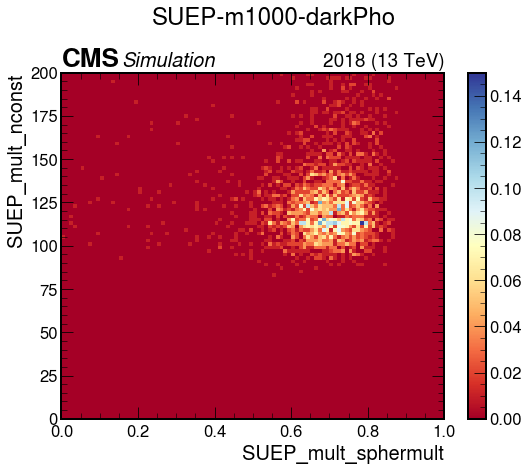

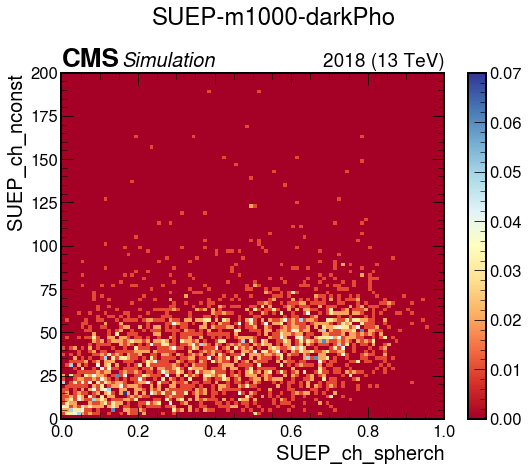

In [171]:
### WORTH ADDING MULTIPLE DATASETS/QCD?
# plots the 2d distributions for a given SUEP dataset
dataset2d = "SUEP-m1000-darkPho+RunIIAutumn18-private+MINIAODSIM"
for plot_label in showlist:
    if 'D_obs' in plot_label and (not unblind): continue
    if '2D' not in plot_label: continue
    save = plot_label in savelist
    
    # define figure, axis on which to plot QCD and SUEP
    fig, ax = plt.subplots(figsize=(8,7))
    hep.cms.label(data=False,year='2018', fontsize=20)
    
    hSUEP = SUEP_plots[dataset2d][plot_label]
    i = find_nth(dataset2d,'+',1)
    l = dataset2d[:i]
    plot2d(hSUEP, ax)
    
    fig.suptitle(l, y=0.95)
    fig.tight_layout()
    fig.show()
    
    if save: fig.savefig(output_label + "_" + plot_label +".pdf", bbox_inches='tight')